# GP optimizer for one single hexapole

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

### Creat the machine interface

In [26]:
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[0.9]]

#creat machine interface
# model_path = 'CNNmodels/VGG16_emit+defocus_test6_attempt3.h5'
model_path = 'CNNmodels/VGG16_30mrademit+defocus_30mradApt_test12_01.h5'
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption = 1, CNNpath = model_path, 
                                DefocusOption = 0, S2 = 1) 
mi.aperture = 30

Model loaded


In [27]:
#check the reading objective is working
print(mi.getState())

/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([[0.9]]), array([[0.78091659]]))


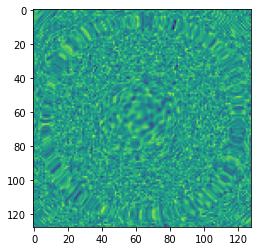

In [28]:
temp = np.load('ronchigram.npy')
plt.imshow(temp)

### Create the gp

In [29]:
gp_ls = np.array(np.ones(ndim)) * [0.542] / 5
gp_amp = 0.162
gp_noise = 6.4e-5
gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))

ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
gp = OGP(ndim, hyperparams)
gp.prmean = 0

### Create the BO

In [30]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])
# opt.ucb_params = np.asarray([0.02, 0.004])
opt.bounds = [(0,1)]
opt.iter_bound = True
# opt.searchBoundScaleFactor = 10

Supposed to be grabbing initial machine state...
x_init [[0.9]]
y_init [[0.78091659]]


**Running BO**

*run the gp search for some number of steps*

In [31]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0])

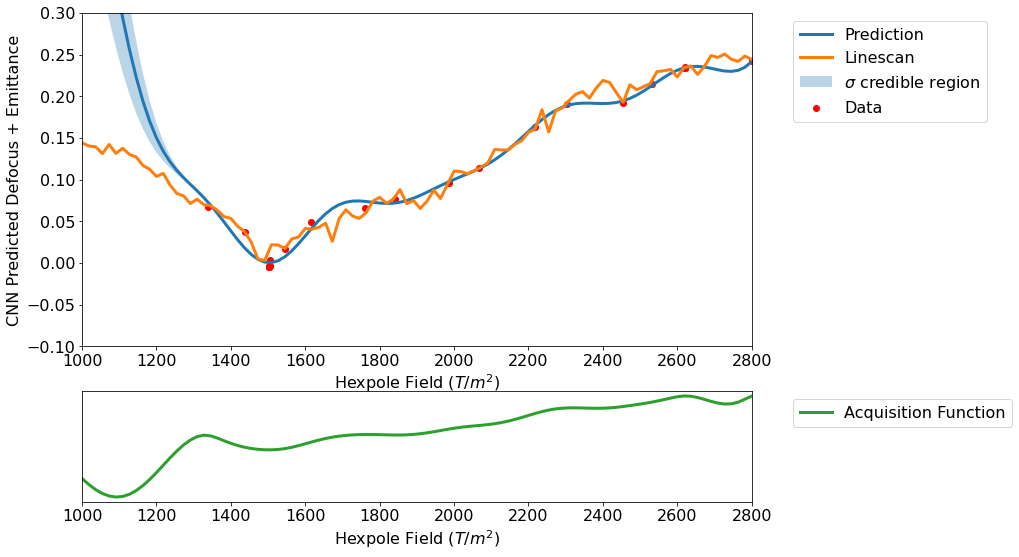

(array([0.27954334]), array([[1.01981696]]))


In [32]:
# Test over single starting point
Niter = 25
Status_array = np.zeros([Niter + 1, 3]) # save the 
Status_array[0,0] = opt.current_x[0][0]
Status_array[0,1] = Status_array[0,2] = mi.getState()[1][0]
emit_profile = np.load('H1_H2_linescan_100steps_normalizedEmit+Defocus.npy')
for i in range(Niter):
    
    print ('iteration =', i)
    print ('current position:', mi.x, 'current best seen objective value:', Obj_state_s[-1])
    pngfile = 'Iteration' + format(i, '02') + '.png'
    
    temp = opt.OptIter() # save the new acquisition point and objective value
    Obj_state_s.append(opt.best_seen()[1]) # save current best value
    Status_array[i+1, 2] = opt.best_seen()[1][0][0]  # best seen objective so far
    Status_array[i+1, 1] = temp[1][0][0]  # objective at new point
    Status_array[i+1, 0] = temp[0][0][0]  # coordinate of new point
    
    clear_output(wait=True)
    
    # Calculate GP value and acquisition function
    x = np.linspace(0,1,num = 100)
    y = x*0
    yval = x*0
    yerr = x*0
    for j in range(len(x)):
        y[j] = negUCB(x[j],opt.model, ndim, i + 1, opt.ucb_params[0], opt.ucb_params[1])
        yval[j] = opt.model.predict(np.array([x[j]],ndmin=2))[0][0]
        yerr[j] = opt.model.predict(np.array([x[j]],ndmin=2))[1][0]
        
    # make plot
    fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3,1]}, figsize = [12,9])

    p1 = a0.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, label = 'Prediction')
    p2 = a0.plot(x * 1800 + 1000, 1.015 - emit_profile, linewidth = '3', label = 'Linescan')
    a0.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, alpha = 0.3, label = '$\sigma$ credible region')
    p3 = a0.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r', label = 'Data')

    a0.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
    a0.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
    a0.tick_params(axis='x', labelsize=16)
    a0.tick_params(axis='y', labelsize=16)
    a0.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1.05, 1])
    a0.set_ylim([-0.1, 0.30])
    a0.set_xlim([1000, 2800])

#     a1.scatter(x[np.argmin(y)] * 1800 + 1000, np.amin(y), s = 100, marker = "*",c='r')
    a1.plot(x * 1800 + 1000, y, linewidth = 3, label = 'Acquisition Function', c = 'C2')
    a1.tick_params(axis='x', labelsize=16)
    a1.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
    a1.set_yticks([])
    a1.tick_params(axis='y', labelsize=16)
    a1.legend(fontsize = 16, bbox_to_anchor = [1.05, 1])
    a1.set_xlim([1000, 2800])

#     ax2 = fig.add_axes([0.7, 0.35, 0.3, 0.4])
#     temp = np.load('ronchigram.npy')
#     ax2.imshow(temp, cmap = 'gray')
#     ax2.set_xticks([])
#     ax2.set_yticks([])
    
    plt.show()
    fig.tight_layout()
#     fig.savefig(pngfile, bbox_inches='tight',facecolor='w')
    
print(opt.best_seen())

In [ ]:
fig, a0 = plt.subplots(1, 1, figsize = [10,6])

p1 = a0.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, label = 'Prediction')
p2 = a0.plot(x * 1800 + 1000, 1.015 - emit_profile, linewidth = '3', label = 'Linescan')
a0.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, alpha = 0.3, label = '$\sigma$ credible region')
p3 = a0.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r', label = 'Data')

a0.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
a0.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
a0.tick_params(axis='x', labelsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.legend(fontsize = 16,loc = 'upper left', bbox_to_anchor = [1.05, 1])
a0.set_ylim([-0.1, 0.30])
a0.set_xlim([1000, 2800])

ax2 = fig.add_axes([0.9, 0.1, 0.4, 0.5])
temp = np.load('ronchigram.npy')
ax2.imshow(temp, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

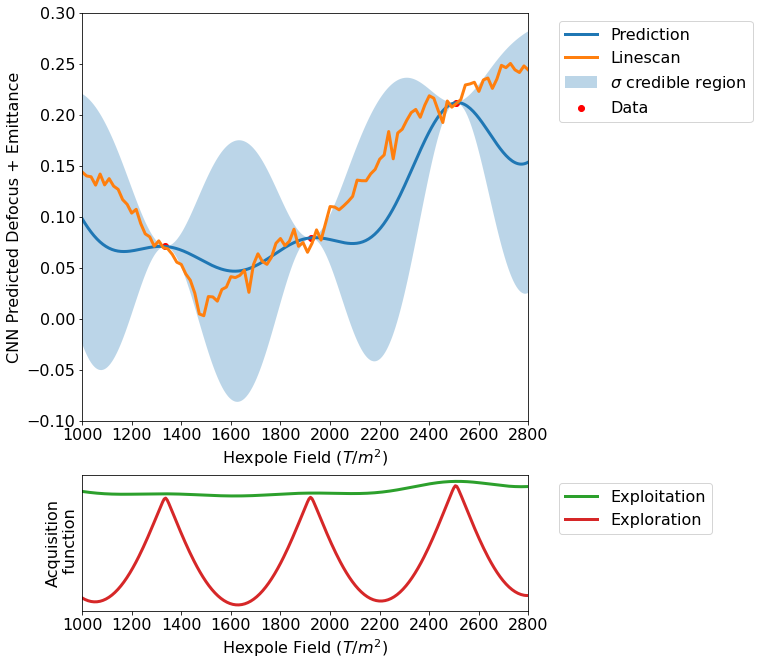

In [33]:
npoints = 300
x = np.linspace(0,1,npoints)
y_1 = x*0
y_2 = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y_1[i] = negUCB(x[i],opt.model, 1, 0, nu = 0.)
    y_2[i] = negUCB(x[i], opt.model, 1, 0, nu = 5)
    yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
    
    # make plot
fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3,1]}, figsize = [8,11])

p1 = a0.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, label = 'Prediction')
p2 = a0.plot(np.linspace(0,1,100) * 1800 + 1000, 1.015 - emit_profile, linewidth = '3', label = 'Linescan')
a0.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, alpha = 0.3, label = '$\sigma$ credible region')
p3 = a0.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r', label = 'Data')

a0.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
a0.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
a0.tick_params(axis='x', labelsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1.05, 1])
a0.set_ylim([-0.1, 0.30])
a0.set_xlim([1000, 2800])

#     a1.scatter(x[np.argmin(y)] * 1800 + 1000, np.amin(y), s = 100, marker = "*",c='r')
a1.plot(x * 1800 + 1000, y_1, linewidth = 3, label = 'Exploitation', c = 'C2')
a1.plot(x * 1800 + 1000, y_2, linewidth = 3, label = 'Exploration', c = 'C3')
a1.tick_params(axis='x', labelsize=16)
a1.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
a1.set_ylabel('Acquisition\n function', fontsize = 16)
a1.set_yticks([])
a1.tick_params(axis='y', labelsize=16)
a1.legend(fontsize = 16, bbox_to_anchor = [1.05, 1])
a1.set_xlim([1000, 2800])


plt.show()
fig.tight_layout()

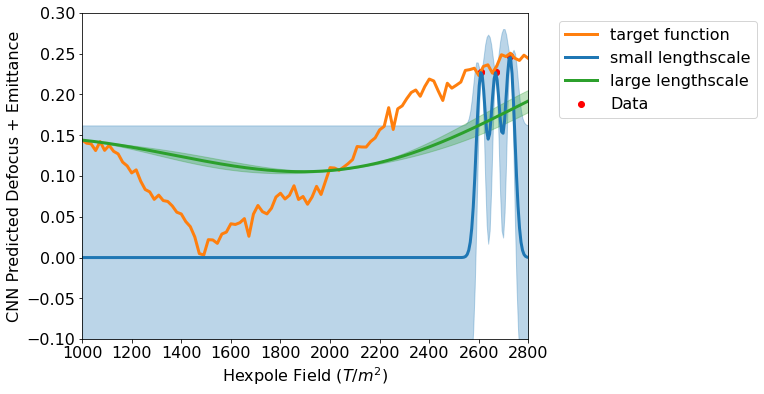

In [21]:
# compare different GP lengthscales

# calculate the data from model with small LS
npoints = 300
x = np.linspace(0,1,npoints)
y = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y[i] = negUCB(x[i],model_smallLS, 1, 0)
    yval[i] = model_smallLS.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = model_smallLS.predict(np.array([x[i]],ndmin=2))[1][0]
    
    # make plot
fig, ax = plt.subplots(1, 1, figsize = [8,6])

p2 = ax.plot(np.linspace(0,1,100) * 1800 + 1000, 1.015 - emit_profile, c='C1', linewidth = '3', label = 'target function')
p3 = ax.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r', label = 'Data')
p1 = ax.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, c='C0', label = 'small lengthscale')
ax.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, alpha = 0.3, color='C0')

# calculate the data from model with large LS
y = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y[i] = negUCB(x[i],model_largeLS, 1, 0)
    yval[i] = model_largeLS.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = model_largeLS.predict(np.array([x[i]],ndmin=2))[1][0]
    
p4 = ax.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, c='C2', label = 'large lengthscale')
ax.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, color = 'C2', alpha = 0.3)
p5 = ax.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r')

ax.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
ax.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1.05, 1])
ax.set_ylim([-0.1, 0.30])
ax.set_xlim([1000, 2800])

plt.show()
fig.tight_layout()

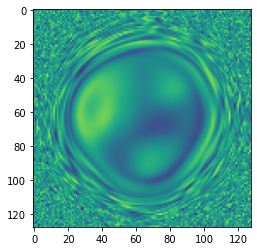

In [207]:
# compare different acquisition function parameters

npoints = 300
x = np.linspace(0,1,npoints)
y = x*0
yval = x*0
yerr = x*0
for i in range(len(x)):
    y[i] = negUCB(x[i],opt.model, 1, 0)
    yval[i] = opt.model.predict(np.array([x[i]],ndmin=2))[0][0]
    yerr[i] = opt.model.predict(np.array([x[i]],ndmin=2))[1][0]
    
    # make plot
fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3,1]}, figsize = [8,11])

p1 = a0.plot(x * 1800 + 1000 ,1.015 - yval, linewidth = 3, label = 'Prediction')
p2 = a0.plot(np.linspace(0,1,100) * 1800 + 1000, 1.015 - emit_profile, linewidth = '3', label = 'Linescan')
a0.fill_between(x * 1800 + 1000, 1.015 - yval - yerr, 1.015 - yval + yerr, alpha = 0.3, label = '$\sigma$ credible region')
p3 = a0.scatter(Status_array[1:i+1, 0] * 1800 + 1000, 1.015-Status_array[1:i+1, 1],c='r', label = 'Data')

a0.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
a0.set_ylabel('CNN Predicted Defocus + Emittance', fontsize = 16)
a0.tick_params(axis='x', labelsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor = [1.05, 1])
a0.set_ylim([-0.1, 0.30])
a0.set_xlim([1000, 2800])

#     a1.scatter(x[np.argmin(y)] * 1800 + 1000, np.amin(y), s = 100, marker = "*",c='r')
a1.plot(x * 1800 + 1000, y, linewidth = 3, label = 'Acquisition Function', c = 'C2')
a1.tick_params(axis='x', labelsize=16)
a1.set_xlabel('Hexpole Field ($T/m^2$)',fontsize = 16)
a1.set_yticks([])
a1.tick_params(axis='y', labelsize=16)
a1.legend(fontsize = 16, bbox_to_anchor = [1.05, 1])
a1.set_xlim([1000, 2800])

#     ax2 = fig.add_axes([0.7, 0.35, 0.3, 0.4])
#     temp = np.load('ronchigram.npy')
#     ax2.imshow(temp, cmap = 'gray')
#     ax2.set_xticks([])
#     ax2.set_yticks([])

plt.show()
fig.tight_layout()

## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.
<br>The calculated emittance vs hexpole current can also be used as a reference for the real objective function during the GP test.

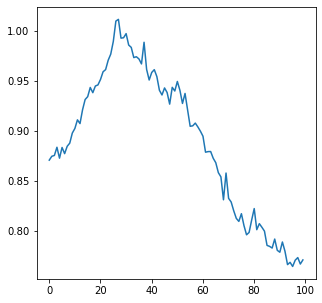

In [42]:
# 1D scan along for H1 value with deltaH=0
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
H1_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption = 1, CNNpath = model_path, 
                            DefocusOption = 0, S2 = 1)
mi.aperture = 30

for i in range(len(H1_list)):
    start_point = [[H1_list[i]]] 
    mi.setX(start_point)
    emit_profile[i] = (mi.getState()[1][0])
    print(H1_list[i], emit_profile[i])
    
    clear_output(wait=True)
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('H1_H2_linescan_100steps_normalizedEmit+Defocus.npy',emit_profile)

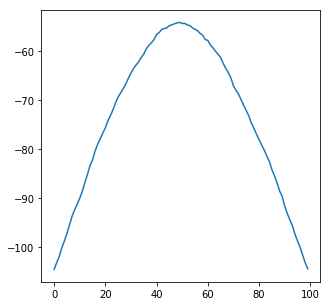

35.0 [[1498, 35.0]] [-104.40404326]


In [8]:
# 1D scan along for deltaH value with H1=1498
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
deltaH_list = np.linspace(-35, 35,num=100)
emit_profile = np.zeros([100,1])

for i in range(len(deltaH_list)):
    start_point = [[1498, deltaH_list[i]]] 
    print(start_point)
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_profile[i] = (mi.getState()[1][0])
    
    clear_output(wait=True)
    fig = plt.figure(figsize = [5,5])
    plt.plot(emit_profile)
    plt.show()
    np.save('deltaH_-35_35_100steps_emittance.npy',emit_profile)
    print(deltaH_list[i], start_point, emit_profile[i])